Installing (updating) the following libraries for your Sagemaker
instance.

In [ ]:
!pip install .. # installing d2l


# Variáveis Aleatórias
:label:`sec_random_variables`

Em :numref:`sec_prob` vimos o básico de como trabalhar com variáveis aleatórias discretas, que em nosso caso se referem àquelas variáveis aleatórias que tomam um conjunto finito de valores possíveis, ou os inteiros. Nesta seção, desenvolvemos a teoria das *variáveis aleatórias contínuas*, que são variáveis aleatórias que podem assumir qualquer valor real.

## Variáveis Aleatórias Contínuas

Variáveis aleatórias contínuas são um tópico significativamente mais sutil do que variáveis aleatórias discretas. Uma boa analogia a ser feita é que o salto técnico é comparável ao salto entre adicionar listas de números e integrar funções. Como tal, precisaremos levar algum tempo para desenvolver a teoria.

### Do Discreto ao Contínuo

Para entender os desafios técnicos adicionais encontrados ao trabalhar com variáveis aleatórias contínuas, vamos realizar um experimento de pensamento. Suponha que estejamos jogando um dardo no alvo e queremos saber a probabilidade de que ele atinja exatamente $2 \text{cm}$  do centro do alvo.


Para começar, imaginamos medir um único dígito de precisão, ou seja, com valores para $0 \text{cm}$, $1 \text{cm}$, $2 \text{cm}$ e assim por diante. Jogamos, digamos, $100$ dardos no alvo de dardos, e se $20$ deles caem no valor de $2\text{cm}$, concluímos que $20\%$ dos dardos que jogamos atingem o tabuleiro $2 \text{cm}$ longe do centro.

No entanto, quando olhamos mais de perto, isso não corresponde à nossa pergunta! Queríamos igualdade exata, ao passo que essas caixas mantêm tudo o que está entre, digamos, $1.5\text{cm}$ e $2.5\text{cm}$.


Sem desanimar, continuamos adiante. Medimos ainda mais precisamente, digamos $1.9\text{cm}$, $2.0\text{cm}$, $2.1\text{cm}$, e agora vemos que talvez $3$ dos $100$ dardos atingiram o tabuleiro no $2.0\text{cm}$ balde. Assim, concluímos que a probabilidade é $3\%$.

Porém, isso não resolve nada! Apenas resolvemos o problema um dígito mais. Vamos abstrair um pouco. Imagine que sabemos a probabilidade de que os primeiros $k$ dígitos correspondam a $2.00000\ldots$ e queremos saber a probabilidade de que correspondam aos primeiros $k+1$ dígitos. É bastante razoável supor que o dígito ${k+1}^{\mathrm{th}}$ é essencialmente uma escolha aleatória do conjunto $\{0, 1, 2, \ldots, 9\}$. Pelo menos, não podemos conceber um processo fisicamente significativo que forçaria o número de micrômetros a se afastar do centro a preferir terminar em $7$ vs $3$.

O que isso significa é que, em essência, cada dígito adicional de precisão que exigimos deve diminuir a probabilidade de correspondência por um fator de $10$. Ou dito de outra forma, poderíamos esperar que

$$
P(\text{distance is}\; 2.00\ldots, \;\text{to}\; k \;\text{digits} ) \approx p\cdot10^{-k}.
$$


O valor $p$ essencialmente codifica o que acontece com os primeiros dígitos, e $10^{-k}$ trata do resto.

Observe que, se conhecermos a posição com precisão de $k=4$ dígitos após o decimal. isso significa que sabemos que o valor está dentro do intervalo, digamos $[(1.99995,2.00005]$, que é um intervalo de comprimento $2.00005-1.99995 = 10^{-4}$. Portanto, se chamarmos o comprimento deste intervalo de $\epsilon$, podemos dizer

$$
P(\text{distance is in an}\; \epsilon\text{-sized interval around}\; 2 ) \approx \epsilon \cdot p.
$$

Vamos dar mais um passo final. Temos pensado nesse ponto $2$ o tempo todo, mas nunca pensando em outros pontos. Nada é fundamentalmente diferente aqui, mas é o caso que o valor $p$ provavelmente será diferente. Esperaríamos pelo menos que um arremessador de dardo tivesse mais probabilidade de acertar um ponto próximo ao centro, como $2\text{cm}$. em vez de $20\text{cm}$. Assim, o valor $p$ não é fixo, mas deve depender do ponto $x$. Isso nos diz que devemos esperar

$$P(\text{distance is in an}\; \epsilon \text{-sized interval around}\; x ) \approx \epsilon \cdot p(x).$$
:eqlabel:`eq_pdf_deriv`

Na verdade, :eqref:`eq_pdf_deriv` define com precisão a *função de densidade de probabilidade*. É uma função $p(x)$ que codifica a probabilidade relativa de acertar perto de um ponto em relação a outro. Vamos visualizar a aparência de tal função.


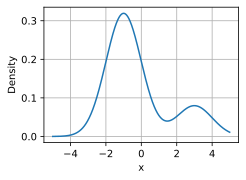

In [1]:
%matplotlib inline
import torch
from IPython import display
from d2l import torch as d2l

torch.pi = torch.acos(torch.zeros(1)).item() * 2  # Define pi in torch

# Plot the probability density function for some random variable
x = torch.arange(-5, 5, 0.01)
p = 0.2*torch.exp(-(x - 3)**2 / 2)/torch.sqrt(2 * torch.tensor(torch.pi)) + \
    0.8*torch.exp(-(x + 1)**2 / 2)/torch.sqrt(2 * torch.tensor(torch.pi))

d2l.plot(x, p, 'x', 'Density')

Os locais onde o valor da função é grande indicam regiões onde é mais provável encontrar o valor aleatório. As porções baixas são áreas onde é improvável que encontremos o valor aleatório.

### Funções de Densidade de Probabilidade

Vamos agora investigar isso mais detalhadamente. Já vimos o que é uma função de densidade de probabilidade intuitivamente para uma variável aleatória $X$, ou seja, a função de densidade é uma função $p(x)$ de modo que

$$P(X \; \text{is in an}\; \epsilon \text{-sized interval around}\; x ) \approx \epsilon \cdot p(x).$$
:eqlabel:`eq_pdf_def`


Mas o que isso implica para as propriedades de $p(x)$?

Primeiro, as probabilidades nunca são negativas, portanto, devemos esperar que $p(x) \ge 0$  também.

Em segundo lugar, vamos imaginar que dividimos $\mathbb{R}$ em um número infinito de fatias de $\epsilon$ de largura, digamos com fatias $(\epsilon\cdot i, \epsilon \cdot (i+1)]$. Para cada um deles, sabemos de :eqref:`eq_pdf_def` que a probabilidade é de aproximadamente

$$
P(X \; \text{is in an}\; \epsilon\text{-sized interval around}\; x ) \approx \epsilon \cdot p(\epsilon \cdot i),
$$

então, resumido sobre todos eles, deveria ser

$$
P(X\in\mathbb{R}) \approx \sum_i \epsilon \cdot p(\epsilon\cdot i).
$$

Isso nada mais é do que a aproximação de uma integral discutida em :numref:`sec_integral_calculus`, portanto, podemos dizer que

$$
P(X\in\mathbb{R}) = \int_{-\infty}^{\infty} p(x) \; dx.
$$

Sabemos que $P(X\in\mathbb{R}) = 1$, uma vez que a variável aleatória deve assumir *algum* número, podemos concluir que para qualquer densidade

$$
\int_{-\infty}^{\infty} p(x) \; dx = 1.
$$

Na verdade, aprofundarmos mais nisso mostra que para qualquer $a$ e $b$, vemos que

$$
P(X\in(a, b]) = \int _ {a}^{b} p(x) \; dx.
$$

Podemos aproximar isso no código usando os mesmos métodos de aproximação discretos de antes. Nesse caso, podemos aproximar a probabilidade de cair na região azul.


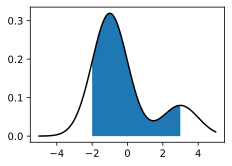

'approximate Probability: 0.773617148399353'

In [2]:
# Approximate probability using numerical integration
epsilon = 0.01
x = torch.arange(-5, 5, 0.01)
p = 0.2*torch.exp(-(x - 3)**2 / 2) / torch.sqrt(2 * torch.tensor(torch.pi)) +\
    0.8*torch.exp(-(x + 1)**2 / 2) / torch.sqrt(2 * torch.tensor(torch.pi))

d2l.set_figsize()
d2l.plt.plot(x, p, color='black')
d2l.plt.fill_between(x.tolist()[300:800], p.tolist()[300:800])
d2l.plt.show()

f'approximate Probability: {torch.sum(epsilon*p[300:800])}'

Acontece que essas duas propriedades descrevem exatamente o espaço das funções de densidade de probabilidade possíveis (ou *f.d.f.* 'S para a abreviação comumente encontrada). Eles são funções não negativas $p(x) \ge 0$ tais que

$$\int_{-\infty}^{\infty} p(x) \; dx = 1.$$
:eqlabel:`eq_pdf_int_one`

Interpretamos essa função usando integração para obter a probabilidade de nossa variável aleatória estar em um intervalo específico:

$$P(X\in(a, b]) = \int _ {a}^{b} p(x) \; dx.$$
:eqlabel:`eq_pdf_int_int`

Em :numref:`sec_distributions` veremos uma série de distribuições comuns, mas vamos continuar trabalhando de forma abstrata.

### Funções de Distribuição Cumulativas


Na seção anterior, vimos a noção de f.d.p. Na prática, esse é um método comumente encontrado para discutir variáveis aleatórias contínuas, mas tem uma armadilha significativa: os valores de f.d.p. não são em si probabilidades, mas sim uma função que devemos integrar para produzir probabilidades. Não há nada de errado em uma densidade ser maior que $10$, desde que não seja maior que $10$ por mais de um intervalo de comprimento $1/10$. Isso pode ser contra-intuitivo, então as pessoas muitas vezes também pensam em termos da *função de distribuição cumulativa*, ou f.d.c., que *é* uma probabilidade.

Em particular, usando :eqref:`eq_pdf_int_int`, definimos o f.d.c. para uma variável aleatória $X$ com densidade $p(x)$ por

$$
F(x) = \int _ {-\infty}^{x} p(x) \; dx = P(X \le x).
$$

Vamos observar algumas propriedades.

* $F(x) \rightarrow 0$ as $x\rightarrow -\infty$.
* $F(x) \rightarrow 1$ as $x\rightarrow \infty$.
* $F(x)$ is non-decreasing ($y > x \implies F(y) \ge F(x)$).
* $F(x)$ is continuous (has no jumps) if $X$ is a continuous random variable.

Com o quarto marcador, observe que isso não seria verdade se $X$ fosse discreto, digamos, tomando os valores $0$ e $1$ ambos com probabilidade $1/2$. Nesse caso

$$
F(x) = \begin{cases}
0 & x < 0, \\
\frac{1}{2} & x < 1, \\
1 & x \ge 1.
\end{cases}
$$

Neste exemplo, vemos um dos benefícios de trabalhar com o cdf, a capacidade de lidar com variáveis aleatórias contínuas ou discretas na mesma estrutura, ou mesmo misturas das duas (lance uma moeda: se cara retornar o lançamento de um dado , se a cauda retornar a distância de um lançamento de dardo do centro de um alvo de dardo).

### Médias


Suponha que estamos lidando com variáveis aleatórias $X$. A distribuição em si pode ser difícil de interpretar. Muitas vezes é útil ser capaz de resumir o comportamento de uma variável aleatória de forma concisa. Os números que nos ajudam a capturar o comportamento de uma variável aleatória são chamados de *estatísticas resumidas*. Os mais comumente encontrados são a *média*, a *variância* e o *desvio padrão*.

A *média* codifica o valor médio de uma variável aleatória. Se tivermos uma variável aleatória discreta $X$, que assume os valores $x_i$ com probabilidades $p_i$, então a média é dada pela média ponderada: some os valores vezes a probabilidade de que a variável aleatória assuma esse valor:

$$\mu_X = E[X] = \sum_i x_i p_i.$$
:eqlabel:`eq_exp_def`


A maneira como devemos interpretar a média (embora com cautela) é que ela nos diz essencialmente onde a variável aleatória tende a estar localizada.

Como um exemplo minimalista que examinaremos ao longo desta seção, tomemos $X$ como a variável aleatória que assume o valor $a-2$ com probabilidade $p$, $a+2$ com probabilidade $p$ e $a$ com probabilidade $1-2p$. Podemos calcular usando :eqref:`eq_exp_def` que, para qualquer escolha possível de $a$ e $p$, a média é

$$
\mu_X = E[X] = \sum_i x_i p_i = (a-2)p + a(1-2p) + (a+2)p = a.
$$


Assim, vemos que a média é $a$. Isso corresponde à intuição, já que $a$ é o local em torno do qual centralizamos nossa variável aleatória.

Por serem úteis, vamos resumir algumas propriedades.

* Para qualquer variável aleatória $X$ e números $a$ e $b$, temos que $\mu_{aX+b} = a\mu_X + b$.
* Se temos duas variáveis aleatórias $X$ e $Y$, temos $\mu_{X+Y} = \mu_X+\mu_Y$.

As médias são úteis para entender o comportamento médio de uma variável aleatória, porém a média não é suficiente para ter um entendimento intuitivo completo. Ter um lucro de $\$10 \pm \$1$ por venda é muito diferente de ganhar $\$10 \pm \$15$ por venda, apesar de ter o mesmo valor médio. O segundo tem um grau de flutuação muito maior e, portanto, representa um risco muito maior. Assim, para entender o comportamento de uma variável aleatória, precisaremos, no mínimo, de mais uma medida: alguma medida de quão amplamente uma variável aleatória flutua.

### Variâncias


Isso nos leva a considerar a *variância* de uma variável aleatória. Esta é uma medida quantitativa de quão longe uma variável aleatória se desvia da média. Considere a expressão $X - \mu_X$. Este é o desvio da variável aleatória de sua média. Esse valor pode ser positivo ou negativo, portanto, precisamos fazer algo para torná-lo positivo para que possamos medir a magnitude do desvio.

Uma coisa razoável a tentar é olhar para $\left|X-\mu_X\right|$, e de fato isso leva a uma quantidade útil chamada *desvio médio absoluto*, no entanto, devido a conexões com outras áreas da matemática e estatística, as pessoas costumam usar uma solução diferente.

Em particular, eles olham para $(X-\mu_X)^2.$. Se olharmos para o tamanho típico desta quantidade tomando a média, chegamos à variância

$$\sigma_X^2 = \mathrm{Var}(X) = E\left[(X-\mu_X)^2\right] = E[X^2] - \mu_X^2.$$
:eqlabel:`eq_var_def`


A última igualdade em :eqref:`eq_var_def` se mantém expandindo a definição no meio e aplicando as propriedades de expectativa.

Vejamos nosso exemplo onde $X$ é a variável aleatória que assume o valor $a-2$ com probabilidade $p$, $a+2$ com probabilidade $p$ e $a$ com probabilidade $1-2p$. Neste caso $\mu_X = a$, então tudo que precisamos calcular é $E\left[X^2\right]$. Isso pode ser feito prontamente:

$$
E\left[X^2\right] = (a-2)^2p + a^2(1-2p) + (a+2)^2p = a^2 + 8p.
$$

Assim, vemos que por :eqref:`eq_var_def` nossa variância é
$$
\sigma_X^2 = \mathrm{Var}(X) = E[X^2] - \mu_X^2 = a^2 + 8p - a^2 = 8p.
$$


Este resultado novamente faz sentido. O maior $p$ pode ser $1/2$ que corresponde a escolher $a-2$ ou $a+2$ com um cara ou coroa. A variação de ser $4$ corresponde ao fato de que $a-2$ e $a+2$ estão $2$ unidades de distância da média e $2^2 = 4$. Na outra extremidade do espectro, se $p=0$, essa variável aleatória sempre assume o valor $0$ e, portanto, não tem nenhuma variação.

Listaremos algumas propriedades de variação abaixo:

* Para qualquer variável aleatória $X$, $\mathrm{Var}(X) \ge 0$, com $\mathrm{Var}(X) = 0$ se e somente se $X$ for uma constante.
* Para qualquer variável aleatória $X$ e números $a$ e $b$, temos que $\mathrm{Var}(aX+b) = a^2\mathrm{Var}(X)$.
* Se temos duas variáveis aleatórias *independentes* $X$ e $Y$, temos $\mathrm{Var}(X+Y) = \mathrm{Var}(X) + \mathrm{Var}(Y)$.

Ao interpretar esses valores, pode haver um pequeno soluço. Em particular, vamos tentar imaginar o que acontece se rastrearmos as unidades por meio desse cálculo. Suponha que estejamos trabalhando com a classificação por estrelas atribuída a um produto na página da web. Então $a$, $a-2$ e $a+2$ são medidos em unidades de estrelas. Da mesma forma, a média $\mu_X$ também é medida em estrelas (sendo uma média ponderada). No entanto, se chegarmos à variância, imediatamente encontramos um problema, que é queremos olhar para $(X-\mu_X)^2$, que está em unidades de *estrelas ao quadrado*. Isso significa que a própria variação não é comparável às medições originais. Para torná-lo interpretável, precisaremos retornar às nossas unidades originais.

### Desvio Padrão

Essas estatísticas resumidas sempre podem ser deduzidas da variância calculando a raiz quadrada! Assim, definimos o *desvio padrão* como sendo

$$
\sigma_X = \sqrt{\mathrm{Var}(X)}.
$$


Em nosso exemplo, isso significa que agora temos o desvio padrão $\sigma_X = 2\sqrt{2p}$. Se estamos lidando com unidades de estrelas para nosso exemplo de revisão, $\sigma_X$ está novamente em unidades de estrelas.

As propriedades que tínhamos para a variância podem ser reapresentadas para o desvio padrão.

* Para qualquer variável aleatória $X$, $\sigma_{X} \ge 0$.
* Para qualquer variável aleatória $X$ e números $a$ e $b$, temos que $\sigma_{aX+b} = |a|\sigma_{X}$
* Se temos duas variáveis aleatórias *independentes* $X$ e $Y$, temos $\sigma_{X+Y} = \sqrt{\sigma_{X}^2 + \sigma_{Y}^2}$.

É natural, neste momento, perguntar: "Se o desvio padrão está nas unidades de nossa variável aleatória original, ele representa algo que podemos desenhar em relação a essa variável aleatória?" A resposta é um sim retumbante! Na verdade, muito parecido com a média informada sobre a localização típica de nossa variável aleatória, o desvio padrão fornece a faixa típica de variação dessa variável aleatória. Podemos tornar isso rigoroso com o que é conhecido como desigualdade de Chebyshev:

$$P\left(X \not\in [\mu_X - \alpha\sigma_X, \mu_X + \alpha\sigma_X]\right) \le \frac{1}{\alpha^2}.$$
:eqlabel:`eq_chebyshev`


Ou, para declará-lo verbalmente no caso de $\alpha=10$, $99\%$ das amostras de qualquer variável aleatória se enquadram nos desvios padrão de $10$ da média. Isso dá uma interpretação imediata de nossas estatísticas de resumo padrão.

Para ver como essa afirmação é bastante sutil, vamos dar uma olhada em nosso exemplo em execução novamente, onde $X$ é a variável aleatória que assume o valor $a-2$ com probabilidade $p$, $a+2$ com probabilidade $p$ e $a$ com probabilidade $1-2p$. Vimos que a média era $a$ e o desvio padrão era $2\sqrt{2p}$. Isso significa que, se tomarmos a desigualdade de Chebyshev :eqref:`eq_chebyshev` com $\alpha = 2$, vemos que a expressão é

$$
P\left(X \not\in [a - 4\sqrt{2p}, a + 4\sqrt{2p}]\right) \le \frac{1}{4}.
$$

Isso significa que $75\%$ do tempo, essa variável aleatória ficará dentro desse intervalo para qualquer valor de $p$. Agora, observe que como $p \rightarrow 0$, este intervalo também converge para o único ponto $a$. Mas sabemos que nossa variável aleatória assume os valores $a-2, a$ e $a+2$ apenas então, eventualmente, podemos ter certeza de que $a-2$ e $a+2$ ficarão fora do intervalo! A questão é: em que $p$ isso acontece. Então, queremos resolver: para que $p$ $a+4\sqrt{2p} = a+2$, que é resolvido quando $p=1/8$, que é *exatamente* o primeiro $p$ onde isso poderia acontecer sem violar nossa alegação de que não mais do que $1/4$  de amostras da distribuição ficariam fora do intervalo ($1/8$ à esquerda e $1/8$ à direita).

Vamos visualizar isso. Mostraremos a probabilidade de obter os três valores como três barras verticais com altura proporcional à probabilidade. O intervalo será desenhado como uma linha horizontal no meio. O primeiro gráfico mostra o que acontece para $p>1/8$ onde o intervalo contém com segurança todos os pontos.


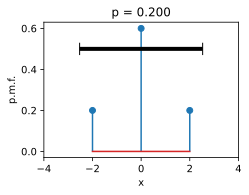

In [3]:
# Define a helper to plot these figures
def plot_chebyshev(a, p):
    d2l.set_figsize()
    d2l.plt.stem([a-2, a, a+2], [p, 1-2*p, p], use_line_collection=True)
    d2l.plt.xlim([-4, 4])
    d2l.plt.xlabel('x')
    d2l.plt.ylabel('p.m.f.')

    d2l.plt.hlines(0.5, a - 4 * torch.sqrt(2 * p),
                   a + 4 * torch.sqrt(2 * p), 'black', lw=4)
    d2l.plt.vlines(a - 4 * torch.sqrt(2 * p), 0.53, 0.47, 'black', lw=1)
    d2l.plt.vlines(a + 4 * torch.sqrt(2 * p), 0.53, 0.47, 'black', lw=1)
    d2l.plt.title(f'p = {p:.3f}')

    d2l.plt.show()

# Plot interval when p > 1/8
plot_chebyshev(0.0, torch.tensor(0.2))

O segundo mostra que em $p = 1/8$, o intervalo toca exatamente os dois pontos. Isso mostra que a desigualdade é *nítida*, uma vez que nenhum intervalo menor pode ser obtido mantendo a desigualdade verdadeira.


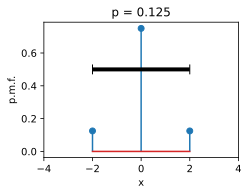

In [4]:
# Plot interval when p = 1/8
plot_chebyshev(0.0, torch.tensor(0.125))

O terceiro mostra que para $p < 1/8$ o intervalo contém apenas o centro. Isso não invalida a desigualdade, pois só precisamos garantir que não mais do que $1/4$ da probabilidade caia fora do intervalo, o que significa que uma vez $p<1/8$, os dois pontos em $a-2$ e $a+2$ podem ser descartados.


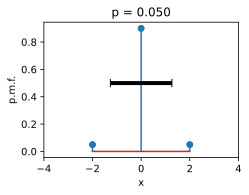

In [5]:
# Plot interval when p < 1/8
plot_chebyshev(0.0, torch.tensor(0.05))

### Médias e Variância no Tempo Contínuo

Tudo isso em termos de variáveis aleatórias discretas, mas o caso das variáveis aleatórias contínuas é semelhante. Para entender intuitivamente como isso funciona, imagine que dividimos a reta do número real em intervalos de comprimento $\epsilon$ dados por $(\epsilon i, \epsilon (i+1)]$. Depois de fazermos isso, nossa variável aleatória contínua foi discretizada e podemos usar :eqref:`eq_exp_def` dizer que

$$
\begin{aligned}
\mu_X & \approx \sum_{i} (\epsilon i)P(X \in (\epsilon i, \epsilon (i+1)]) \\
& \approx \sum_{i} (\epsilon i)p_X(\epsilon i)\epsilon, \\
\end{aligned}
$$

onde $p_X$ é a densidade de $X$. Esta é uma aproximação da integral de $xp_X(x)$, então podemos concluir que

$$
\mu_X = \int_{-\infty}^\infty xp_X(x) \; dx.
$$

Da mesma forma, usando :eqref:`eq_var_def` a variância pode ser escrita como

$$
\sigma^2_X = E[X^2] - \mu_X^2 = \int_{-\infty}^\infty x^2p_X(x) \; dx - \left(\int_{-\infty}^\infty xp_X(x) \; dx\right)^2.
$$

Tudo o que foi dito acima sobre a média, a variância e o desvio padrão ainda se aplica neste caso. Por exemplo, se considerarmos a variável aleatória com densidade

$$
p(x) = \begin{cases}
1 & x \in [0,1], \\
0 & \text{otherwise}.
\end{cases}
$$

nós podemos computar

$$
\mu_X = \int_{-\infty}^\infty xp(x) \; dx = \int_0^1 x \; dx = \frac{1}{2}.
$$

e

$$
\sigma_X^2 = \int_{-\infty}^\infty x^2p(x) \; dx - \left(\frac{1}{2}\right)^2 = \frac{1}{3} - \frac{1}{4} = \frac{1}{12}.
$$

Como um aviso, vamos examinar mais um exemplo, conhecido como a *Distribuição Cauchy*. Esta é a distribuição com f.d.p. dada por

$$
p(x) = \frac{1}{1+x^2}.
$$


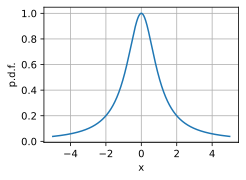

In [6]:
# Plot the Cauchy distribution p.d.f.
x = torch.arange(-5, 5, 0.01)
p = 1 / (1 + x**2)

d2l.plot(x, p, 'x', 'p.d.f.')

Esta função parece inocente e, de fato, consultar uma tabela de integrais mostrará que ela tem a área um abaixo dela e, portanto, define uma variável aleatória contínua.

Para ver o que está errado, vamos tentar calcular a variância disso. Isso envolveria o uso de computação :eqref:`eq_var_def`

$$
\int_{-\infty}^\infty \frac{x^2}{1+x^2}\; dx.
$$

A função interna é semelhante a esta:


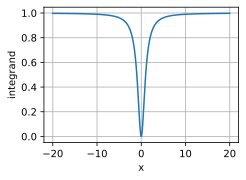

In [7]:
# Plot the integrand needed to compute the variance
x = torch.arange(-20, 20, 0.01)
p = x**2 / (1 + x**2)

d2l.plot(x, p, 'x', 'integrand')

Esta função tem claramente uma área infinita sob ela, uma vez que é essencialmente a constante com um pequeno mergulho próximo a zero, e de fato podemos mostrar que

$$
\int_{-\infty}^\infty \frac{x^2}{1+x^2}\; dx = \infty.
$$


Isso significa que não tem uma variância finita bem definida.

No entanto, olhar mais a fundo mostra um resultado ainda mais perturbador. Vamos tentar calcular a média usando :eqref:`eq_exp_def`. Usando a fórmula de mudança de variáveis, vemos

$$
\mu_X = \int_{-\infty}^{\infty} \frac{x}{1+x^2} \; dx = \frac{1}{2}\int_1^\infty \frac{1}{u} \; du.
$$

A integral interna é a definição do logaritmo, então isso é em essência $\log(\infty) = \infty$, então também não há um valor médio bem definido!

Os cientistas do aprendizado de máquina definem seus modelos de modo que, na maioria das vezes, não precisemos lidar com essas questões e, na grande maioria dos casos, lidaremos com variáveis aleatórias com médias e variações bem definidas. No entanto, de vez em quando variáveis aleatórias com *caudas pesadas* (ou seja, aquelas variáveis aleatórias onde as probabilidades de obter grandes valores são grandes o suficiente para tornar coisas como a média ou variância indefinidas) são úteis na modelagem de sistemas físicos, portanto, vale a pena saber que elas existem.

### Funções de Densidade Conjunta

Todo o trabalho acima assume que estamos trabalhando com uma única variável aleatória de valor real. Mas e se estivermos lidando com duas ou mais variáveis aleatórias potencialmente altamente correlacionadas? Esta circunstância é a norma no *machine learning*: imagine variáveis aleatórias como $R_{i, j}$ que codificam o valor vermelho do pixel na coordenada $(i, j)$ em uma imagem, ou $P_t$ que é um variável aleatória dada por um preço de ação no momento $t$. Pixels próximos tendem a ter cores semelhantes e tempos próximos tendem a ter preços semelhantes. Não podemos tratá-los como variáveis aleatórias separadas e esperar criar um modelo de sucesso (veremos em :numref:`sec_naive_bayes` um modelo com desempenho inferior devido a tal suposição). Precisamos desenvolver a linguagem matemática para lidar com essas variáveis aleatórias contínuas correlacionadas.

Felizmente, com as integrais múltiplas em :numref:`sec_integral_calculus` podemos desenvolver tal linguagem. Suponha que temos, para simplificar, duas variáveis aleatórias $X, Y$ que podem ser correlacionadas. Então, semelhante ao caso de uma única variável, podemos fazer a pergunta:

$$
P(X \;\text{is in an}\; \epsilon \text{-sized interval around}\; x \; \text{and} \;Y \;\text{is in an}\; \epsilon \text{-sized interval around}\; y ).
$$

Raciocínio semelhante ao caso de variável única mostra que isso deve ser aproximadamente

$$
P(X \;\text{is in an}\; \epsilon \text{-sized interval around}\; x \; \text{and} \;Y \;\text{is in an}\; \epsilon \text{-sized interval around}\; y ) \approx \epsilon^{2}p(x, y),
$$

para alguma função $p(x, y)$. Isso é conhecido como densidade conjunta de $X$ e $Y$. Propriedades semelhantes são verdadeiras para isso, como vimos no caso de variável única. Nomeadamente:

* $p(x, y) \ge 0$;
* $\int _ {\mathbb{R}^2} p(x, y) \;dx \;dy = 1$;
* $P((X, Y) \in \mathcal{D}) = \int _ {\mathcal{D}} p(x, y) \;dx \;dy$.

Dessa forma, podemos lidar com múltiplas variáveis aleatórias potencialmente correlacionadas. Se quisermos trabalhar com mais de duas variáveis aleatórias, podemos estender a densidade multivariada para tantas coordenadas quantas desejar, considerando $p(\mathbf{x}) = p(x_1, \ldots, x_n)$. As mesmas propriedades de ser não negativo e ter integral total de um ainda são válidas.

### Distribuições Marginais
Ao lidar com várias variáveis, muitas vezes queremos ser capazes de ignorar os relacionamentos e perguntar: "como essa variável é distribuída?" Essa distribuição é chamada de *distribuição marginal*.

Para ser concreto, vamos supor que temos duas variáveis aleatórias $X, Y$ com densidade conjunta dada por $p _ {X, Y}(x, y)$. Estaremos usando o subscrito para indicar para quais variáveis aleatórias se destina a densidade. A questão de encontrar a distribuição marginal é pegar essa função e usá-la para encontrar $p_X(x)$.

Como acontece com a maioria das coisas, é melhor retornar ao quadro intuitivo para descobrir o que deve ser verdade. Lembre-se de que a densidade é a função $p _ X$ para que

$$
P(X \in [x, x+\epsilon]) \approx \epsilon \cdot p _ X(x).
$$

Não há menção de $Y$, mas se tudo o que recebemos é $p _{X, Y}$, precisamos incluir $Y$ de alguma forma. Podemos primeiro observar que isso é o mesmo que

$$
P(X \in [x, x+\epsilon] \text{, and } Y \in \mathbb{R}) \approx \epsilon \cdot p _ X(x).
$$

Nossa densidade não nos diz diretamente sobre o que acontece neste caso, precisamos dividir em pequenos intervalos em $y$ também, para que possamos escrever isso como

$$
\begin{aligned}
\epsilon \cdot p _ X(x) & \approx \sum _ {i} P(X \in [x, x+\epsilon] \text{, and } Y \in [\epsilon \cdot i, \epsilon \cdot (i+1)]) \\
& \approx \sum _ {i} \epsilon^{2} p _ {X, Y}(x, \epsilon\cdot i).
\end{aligned}
$$

![Somando ao longo das colunas de nosso conjunto de probabilidades, podemos obter a distribuição marginal apenas para a variável aleatória representada ao longo do eixo $x$.](../img/marginal.svg)
:label:`fig_marginal`

Isso nos diz para somar o valor da densidade ao longo de uma série de quadrados em uma linha, como é mostrado em :numref:`fig_marginal`. De fato, depois de cancelar um fator de épsilon de ambos os lados, e reconhecer que a soma à direita é a integral sobre $y$, podemos concluir que

$$
\begin{aligned}
 p _ X(x) &  \approx \sum _ {i} \epsilon p _ {X, Y}(x, \epsilon\cdot i) \\
 & \approx \int_{-\infty}^\infty p_{X, Y}(x, y) \; dy.
\end{aligned}
$$

Assim vemos

$$
p _ X(x) = \int_{-\infty}^\infty p_{X, Y}(x, y) \; dy.
$$

Isso nos diz que, para obter uma distribuição marginal, integramos as variáveis com as quais não nos importamos. Este processo é frequentemente referido como *integração* ou *marginalização* das variáveis desnecessárias.

### Covariância

Ao lidar com várias variáveis aleatórias, há uma estatística de resumo adicional que é útil saber: a *covariância*. Isso mede o grau em que duas variáveis aleatórias flutuam juntas.

Suponha que temos duas variáveis aleatórias $X$ e $Y$, para começar, suponhamos que sejam discretas, assumindo os valores $(x_i, y_j)$ com probabilidade $p_ {ij}$. Neste caso, a covariância é definida como

$$\sigma_{XY} = \mathrm{Cov}(X, Y) = \sum_{i, j} (x_i - \mu_X) (y_j-\mu_Y) p_{ij}. = E[XY] - E[X]E[Y].$$
:eqlabel:`eq_cov_def`

Para pensar sobre isso intuitivamente: considere o seguinte par de variáveis aleatórias. Suponha que $X$ assume os valores $1$ e $3$, e $Y$ assume os valores $-1$ e $3$. Suponha que temos as seguintes probabilidades

$$
\begin{aligned}
P(X = 1 \; \text{and} \; Y = -1) & = \frac{p}{2}, \\
P(X = 1 \; \text{and} \; Y = 3) & = \frac{1-p}{2}, \\
P(X = 3 \; \text{and} \; Y = -1) & = \frac{1-p}{2}, \\
P(X = 3 \; \text{and} \; Y = 3) & = \frac{p}{2},
\end{aligned}
$$

onde $p$ é um parâmetro em $[0,1]$ que escolhemos. Observe que se $p=1$ então eles são sempre seus valores mínimo ou máximo simultaneamente, e se $p=0$ eles têm a garantia de obter seus valores invertidos simultaneamente (um é grande quando o outro é pequeno e vice-versa). Se $p=1/2$, então as quatro possibilidades são todas igualmente prováveis e nenhuma deve estar relacionada. Vamos calcular a covariância. Primeiro, observe $\mu_X = 2$ e $\mu_Y = 1$, então podemos calcular usando :eqref:`eq_cov_def`:

$$
\begin{aligned}
\mathrm{Cov}(X, Y) & = \sum_{i, j} (x_i - \mu_X) (y_j-\mu_Y) p_{ij} \\
& = (1-2)(-1-1)\frac{p}{2} + (1-2)(3-1)\frac{1-p}{2} + (3-2)(-1-1)\frac{1-p}{2} + (3-2)(3-1)\frac{p}{2} \\
& = 4p-2.
\end{aligned}
$$

Quando $p=1$ (o caso em que ambos são maximamente positivos ou negativos ao mesmo tempo) tem uma covariância de $2$. Quando $p=0$ (o caso em que eles são invertidos) a covariância é $-2$. Finalmente, quando $p=1/2$ (o caso em que não estão relacionados), a covariância é $0$. Assim, vemos que a covariância mede como essas duas variáveis aleatórias estão relacionadas.

Uma nota rápida sobre a covariância é que ela mede apenas essas relações lineares. Relacionamentos mais complexos, como $X = Y^2$, em que $Y$ é escolhido aleatoriamente de $\{-2, -1, 0, 1, 2\}$ com igual probabilidade, podem ser perdidos. De fato, um cálculo rápido mostra que essas variáveis aleatórias têm covariância zero, apesar de uma ser uma função determinística da outra.

Para variáveis aleatórias contínuas, a mesma história se aplica. Neste ponto, estamos bastante confortáveis em fazer a transição entre discreto e contínuo, então forneceremos o análogo contínuo de :eqref:`eq_cov_def` sem qualquer derivação.

$$
\sigma_{XY} = \int_{\mathbb{R}^2} (x-\mu_X)(y-\mu_Y)p(x, y) \;dx \;dy.
$$

Para visualização, vamos dar uma olhada em uma coleção de variáveis aleatórias com covariância ajustável.


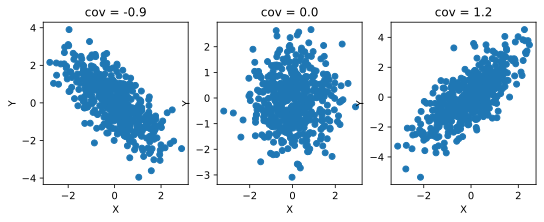

In [8]:
# Plot a few random variables adjustable covariance
covs = [-0.9, 0.0, 1.2]
d2l.plt.figure(figsize=(12, 3))
for i in range(3):
    X = torch.randn(500)
    Y = covs[i]*X + torch.randn(500)

    d2l.plt.subplot(1, 4, i+1)
    d2l.plt.scatter(X.numpy(), Y.numpy())
    d2l.plt.xlabel('X')
    d2l.plt.ylabel('Y')
    d2l.plt.title(f'cov = {covs[i]}')
d2l.plt.show()

Vejamos algumas propriedades das covariâncias:

* Para qualquer variável aleatória $X$, $\mathrm{Cov}(X, X) = \mathrm{Var}(X)$.
* Para quaisquer variáveis aleatórias $X, Y$ e números $a$ e $b$, $\mathrm{Cov}(aX+b, Y) = \mathrm{Cov}(X, aY+b) = a\mathrm{Cov}(X, Y)$.
* Se $X$ e $Y$ são independentes, então $\mathrm{Cov}(X, Y) = 0$.

Além disso, podemos usar a covariância para expandir um relacionamento que vimos antes. Lembre-se de que $X$ e $Y$ são duas variáveis aleatórias independentes, então

$$
\mathrm{Var}(X+Y) = \mathrm{Var}(X) + \mathrm{Var}(Y).
$$

Com o conhecimento das covariâncias, podemos expandir essa relação. Na verdade, alguma álgebra pode mostrar que, em geral,

$$
\mathrm{Var}(X+Y) = \mathrm{Var}(X) + \mathrm{Var}(Y) + 2\mathrm{Cov}(X, Y).
$$

Isso nos permite generalizar a regra de soma de variância para variáveis aleatórias correlacionadas.

### Correlation

Como fizemos no caso das médias e variações, consideremos agora as unidades. Se $X$ é medido em uma unidade (digamos polegadas) e $Y$ é medido em outra (digamos dólares), a covariância é medida no produto dessas duas unidades $\text{inches} \times \text{dollars}$.  Essas unidades podem ser difíceis de interpretar. O que muitas vezes queremos neste caso é uma medida de parentesco sem unidade. Na verdade, muitas vezes não nos importamos com a correlação quantitativa exata, mas, em vez disso, perguntamos se a correlação está na mesma direção e quão forte é a relação.

Para ver o que faz sentido, vamos realizar um experimento mental. Suponha que convertamos nossas variáveis aleatórias em polegadas e dólares em polegadas e centavos. Nesse caso, a variável aleatória $Y$ é multiplicada por $100$. Se trabalharmos com a definição, isso significa que $\mathrm{Cov}(X, Y)$ será multiplicado por $100$. Assim, vemos que, neste caso, uma mudança de unidades altera a covariância por um fator de $100$. Assim, para encontrar nossa medida de correlação invariante à unidade, precisaremos dividir por algo mais que também é escalado por $100$. Na verdade, temos um candidato claro, o desvio padrão! Na verdade, se definirmos o *coeficiente de correlação* como sendo

$$\rho(X, Y) = \frac{\mathrm{Cov}(X, Y)}{\sigma_{X}\sigma_{Y}},$$
:eqlabel:`eq_cor_def`

vemos que este é um valor sem unidade. Um pouco de matemática pode mostrar que este número está entre $-1$ e $1$ com $1$ significando correlacionado positivamente ao máximo, enquanto $-1$ significa correlacionado negativamente ao máximo.

Voltando ao nosso exemplo discreto explícito acima, podemos ver que $\sigma_X = 1$ and $\sigma_Y = 2$, então podemos calcular a correlação entre as duas variáveis aleatórias usando :eqref:`eq_cor_def` para ver que

$$
\rho(X, Y) = \frac{4p-2}{1\cdot 2} = 2p-1.
$$

Isso agora varia entre $-1$ e $1$ com o comportamento esperado de $1$ significando mais correlacionado e $-1$ significando minimamente correlacionado.

Como outro exemplo, considere $X$ como qualquer variável aleatória e $Y=aX+b$ como qualquer função determinística linear de $X$. Então, pode-se calcular que

$$\sigma_{Y} = \sigma_{aX+b} = |a|\sigma_{X},$$

$$\mathrm{Cov}(X, Y) = \mathrm{Cov}(X, aX+b) = a\mathrm{Cov}(X, X) = a\mathrm{Var}(X),$$

e assim por :eqref:`eq_cor_def` que

$$
\rho(X, Y) = \frac{a\mathrm{Var}(X)}{|a|\sigma_{X}^2} = \frac{a}{|a|} = \mathrm{sign}(a).
$$


Assim, vemos que a correlação é $+1$ para qualquer $a > 0$, e $-1$ para qualquer $a <0$, ilustrando que a correlação mede o grau e a direcionalidade em que as duas variáveis aleatórias estão relacionadas, não a escala que a variação leva.

Deixe-nos mais uma vez plotar uma coleção de variáveis aleatórias com correlação ajustável.


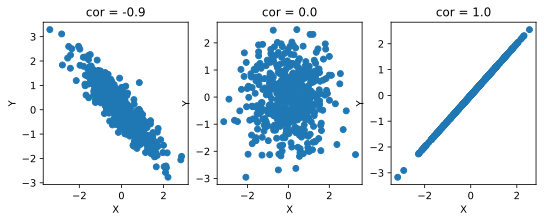

In [9]:
# Plot a few random variables adjustable correlations
cors = [-0.9, 0.0, 1.0]
d2l.plt.figure(figsize=(12, 3))
for i in range(3):
    X = torch.randn(500)
    Y = cors[i] * X + torch.sqrt(torch.tensor(1) -
                                 cors[i]**2) * torch.randn(500)

    d2l.plt.subplot(1, 4, i + 1)
    d2l.plt.scatter(X.numpy(), Y.numpy())
    d2l.plt.xlabel('X')
    d2l.plt.ylabel('Y')
    d2l.plt.title(f'cor = {cors[i]}')
d2l.plt.show()

Vamos listar algumas propriedades da correlação abaixo.

* Para qualquer variável aleatória $X$, $\rho(X, X) = 1$.
* Para quaisquer variáveis aleatórias $X, Y$  e números $a$ e $b$, $\rho(aX+b, Y) = \rho(X, aY+b) = \rho(X, Y)$.
* Se $X$ e $Y$ são independentes com variância diferente de zero então $\rho(X, Y) = 0$.

Como nota final, você pode achar que algumas dessas fórmulas são familiares. Na verdade, se expandirmos tudo assumindo que $\mu_X = \mu_Y = 0$, vemos que isso é

$$
\rho(X, Y) = \frac{\sum_{i, j} x_iy_ip_{ij}}{\sqrt{\sum_{i, j}x_i^2 p_{ij}}\sqrt{\sum_{i, j}y_j^2 p_{ij}}}.
$$

Isso se parece com a soma de um produto dos termos dividido pela raiz quadrada das somas dos termos. Esta é exatamente a fórmula para o cosseno do ângulo entre dois vetores $\mathbf{v}, \mathbf{w}$ com as diferentes coordenadas ponderadas por $p_{ij}$:

$$
\cos(\theta) = \frac{\mathbf{v}\cdot \mathbf{w}}{\|\mathbf{v}\|\|\mathbf{w}\|} = \frac{\sum_{i} v_iw_i}{\sqrt{\sum_{i}v_i^2}\sqrt{\sum_{i}w_i^2}}.
$$

Na verdade, se pensarmos nas normas como sendo relacionadas a desvios-padrão e correlações como cossenos de ângulos, muito da intuição que temos da geometria pode ser aplicada ao pensamento sobre variáveis aleatórias.

## Resumo
* Variáveis ​​aleatórias contínuas são variáveis ​​aleatórias que podem assumir uma sequência contínua de valores. Eles têm algumas dificuldades técnicas que os tornam mais desafiadores de trabalhar em comparação com variáveis ​​aleatórias discretas.
* A função de densidade de probabilidade nos permite trabalhar com variáveis ​​aleatórias contínuas, fornecendo uma função em que a área sob a curva em algum intervalo fornece a probabilidade de encontrar um ponto de amostra nesse intervalo.
* A função de distribuição cumulativa é a probabilidade de observar que a variável aleatória é menor que um determinado limite. Ele pode fornecer um ponto de vista alternativo útil que unifica variáveis ​​discretas e contínuas.
* A média é o valor médio de uma variável aleatória.
* A variância é o quadrado esperado da diferença entre a variável aleatória e sua média.
* O desvio padrão é a raiz quadrada da variância. Pode ser pensado como medir a faixa de valores que a variável aleatória pode assumir.
* A desigualdade de Chebyshev nos permite tornar essa intuição rigorosa, fornecendo um intervalo explícito que contém a variável aleatória na maior parte do tempo.
* As densidades conjuntas nos permitem trabalhar com variáveis ​​aleatórias correlacionadas. Podemos marginalizar as densidades conjuntas integrando variáveis ​​aleatórias indesejadas para obter a distribuição da variável aleatória desejada.
* A covariância e o coeficiente de correlação fornecem uma maneira de medir qualquer relação linear entre duas variáveis ​​aleatórias correlacionadas.

## Exercícios
1. Suponha que temos a variável aleatória com densidade dada por $p(x) = \frac{1}{x^2}$ para $x \ge 1$ e $p(x) = 0$ caso contrário. Quanto é $P(X > 2)$?
2. A distribuição de Laplace é uma variável aleatória cuja densidade é dada por $p(x = \frac{1}{2}e^{-|x|}$. Qual é a média e o desvio padrão desta função? uma dica, $\int_0^\infty xe^{-x} \; dx = 1$ e $\int_0^\infty x^2e^{-x} \; dx = 2$.
3. Eu ando até você na rua e digo "Eu tenho uma variável aleatória com média $1$, desvio padrão $2$, e observei $25\%$ de minhas amostras tendo um valor maior que $9$." Você acredita em mim? Por que ou por que não?
4. Suponha que você tenha duas variáveis aleatórias $X, Y$, com densidade conjunta dada por $p_{XY}(x, y) = 4xy$ para $x, y \in [0,1]$ e $p_{XY}(x, y) = 0$ caso contrário. Qual é a covariância de $X$ e $Y$?


[Discussões](https://discuss.d2l.ai/t/1094)


<!--stackedit_data:
eyJoaXN0b3J5IjpbLTkzODk5MTMyNiwxMTQ1NjE5MzcsLTkyNj
EyMDQwNSwtMzI0MTg5NDg0LC0xMjc2NDE3NTQxLC0zMzg4MjQ5
NCwtMTUyNTEyMTg2MCwtODM2MTIwODIxLDE3ODY4MTkwMjQsNT
U1OTA0MDYsLTE5MzA0MDY2MjEsMzk0MDI0MTc0LC0xNjg3NTk1
NTcxLC01MTY3OTMyNzksMTcyOTg3ODg0LDE2NDc1MTY2MjEsND
M3ODU2NTMxLDY3MDM2MDQwNCwyMTI0NjQ1OTU5LC00NDUwNTgy
OTZdfQ==
-->
